In [1]:
# basic DS imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

# time series imports
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.api import Holt
from prophet import Prophet

# custom function imports
from acquire import *
from explore import *

# shhhh (clean report without notifications of plot size issues, etc.)
import warnings
warnings.filterwarnings("ignore")

---

#### Planning
Goal:
- Project Objective: Use Time Series Predictions to Predict the Weather for Seoul, South Korea. Predicting a year.

Deliverables:
- acquire.py : Functions to reproduce Acquiring and Cleaning of Data.
- explore.py : Functions to reproduce Exploring the Data.
- model.py : Functions to reproduce Modeling the Data.
- Final Notebook (ipynb) : Notebook with steps to reproduce. 

---
#### Data Acquisition and Data Preparations
Using our acquire.py, we'll Acquire the data from the .csv downloaded from (https://www.kaggle.com/datasets/berkeleyearth/climate-change-earth-surface-temperature-data), we utilize the following two .csv from it:
- GlobalLandTemperaturesByCountry.csv
- GlobalLandTemperaturesByMajorCity.csv

Our function will remove the null rows, convert the dt column from object to datetime, set the index to dt, drop irrelevent columns, rename columns for joining, and joins dataframes together.

As well as, plot the mean of seoul average temp and south_korea average temp at 1 month, 3 months, 6 months, and a year.

Then add a difference column, that takes the difference between the South Korean Average with the Seoul Average.
Before returning the Data Frames left joined on index.

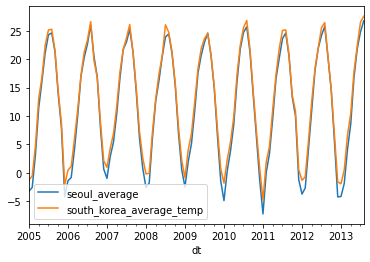

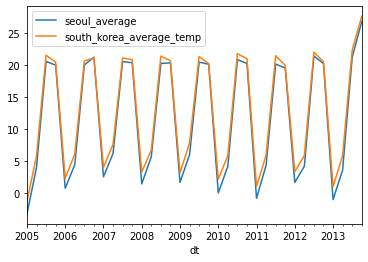

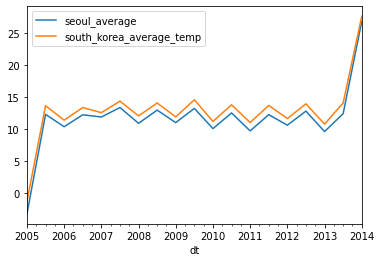

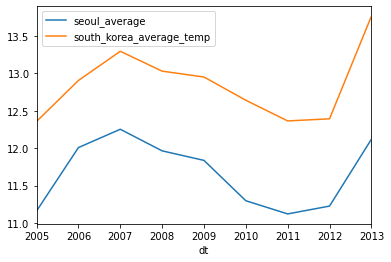

In [2]:
# getting the joined data frames for Seoul and all of South Korea plus the difference in temperature. And some charts showing 1 month, 3 months, 6 months, and 1 year means.
df = wrangle_seoul()

In [3]:
# A peek at our DataFrame
df.head()

,seoul_average,south_korea_average_temp,difference
dt,,,
2005-01-01,-3.260,-1.312,1.948
2005-02-01,-2.614,-0.589,2.025
2005-03-01,3.197,4.777,1.580
2005-04-01,11.411,13.071,1.660
2005-05-01,16.160,16.877,0.717


In [4]:
# checking the stats with .describe()
df.describe()

,seoul_average,south_korea_average_temp,difference
count,104.000000,104.000000,104.000000
mean,11.648019,12.819087,1.171067
std,10.036293,9.489136,0.749039
min,-7.279000,-4.818000,-0.722000
25%,3.109000,4.570750,0.630250
50%,12.981500,13.394500,1.166500
75%,21.125500,21.640250,1.739750
max,26.791000,27.601000,3.083000


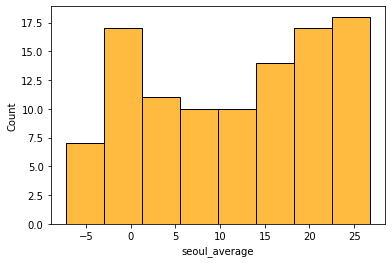

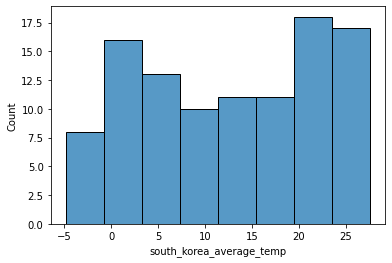

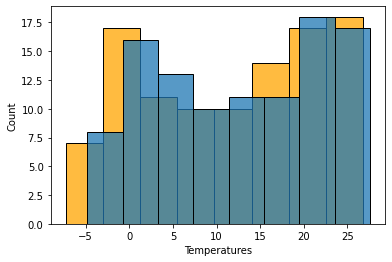

In [5]:
# Now Histograms of Seoul's temp and South Korea's Temp
histoplots(df)

##### Summary:
Data Cleaned, Scaled, and Charted. The Average for Seoul is very similar to South Korea as a whole, except Seoul is slightly colder. So, We'll predict Seoul, South Korea, and the Difference in the long run.

---

#### Data Exploration

Splitting the Data into train, validate, and test before starting some exploration.

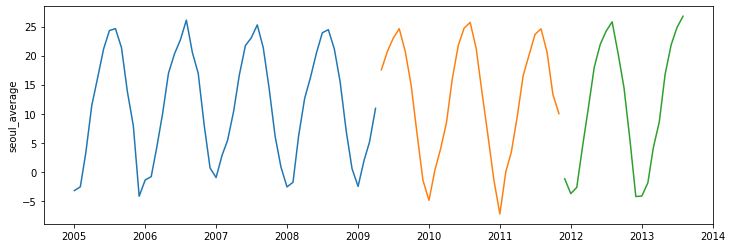

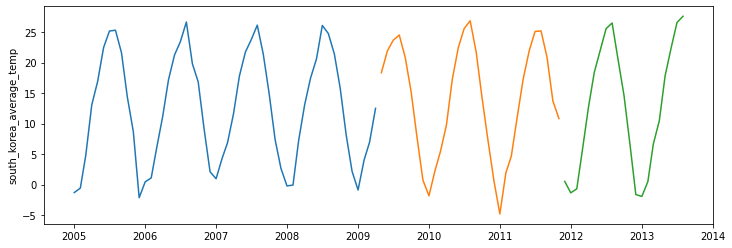

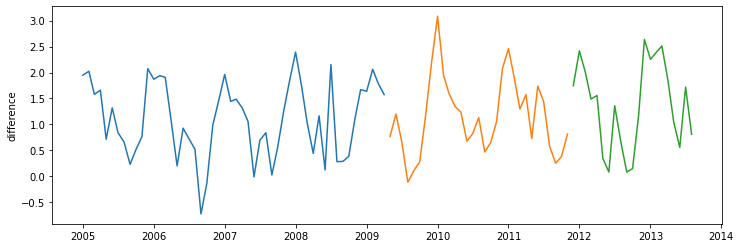

In [6]:
train, validate, test = split(df)

In [7]:
corr, p = correlation(train)

Correlation : 0.9986328749191393
    p-value : 9.212700035670795e-66
